# Classifying brain metastases in MRIs using a 3D CNN

## Import libraries

In [23]:
import tensorflow as tf
# import tensorboard
import nibabel as nib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

## Prepare data for training
To-do:
- load nifti files and compress all 4 sequences into one array (also consider using the different sequences as different "colors")
- one hot encode sex

(140, 165, 143)
(140, 165, 143)
(140, 165, 143)
(140, 165, 143)


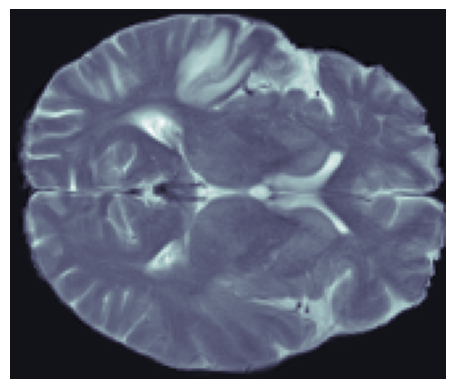

In [60]:
path_to_images_folder = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/preprocessedn5"
path_to_tsv = path_to_images_folder + "/participants.tsv"

patients = pd.read_csv(path_to_tsv, sep="\t")

patient_features = patients.copy()
patient_labels = patient_features.pop("primary")

# load niftis
patient_folder = [
    folder for folder in os.listdir(path_to_images_folder) if os.path.isdir(os.path.join(path_to_images_folder, folder))
]

path_to_example_image = os.path.join(path_to_images_folder, patient_folder[4])
example_images = os.listdir(path_to_example_image)

paths = []
for image in example_images:
    paths.append(os.path.join(path_to_example_image, image))

nifti_images = []

for image in example_images:
    nifti_images.append(nib.load(os.path.join(path_to_example_image, image)))

np_images = []

for nifti in nifti_images:
    np_images.append(nifti.get_fdata())

for image in np_images:
    print(image.shape)

plt.imshow(np_images[2][:,:,70], cmap="bone")
plt.axis("off")
plt.show()

In [55]:
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom

def load_and_resize_nifti(file_path, target_shape):
    # Load NIfTI file
    img = nib.load(file_path)
    
    # Get the image data
    img_data = img.get_fdata()

    # Resize or pad the image to the target shape
    resized_img = resize_or_pad(img_data, target_shape)

    return resized_img

def resize_or_pad(img_data, target_shape):
    # Get the current image shape
    current_shape = img_data.shape

    # Calculate the scaling factors for resizing
    scaling_factors = [target_dim / current_dim for target_dim, current_dim in zip(target_shape, current_shape)]

    # Use scipy's zoom function to resize the image
    resized_img = zoom(img_data, scaling_factors, order=1, mode='nearest')

    return resized_img

# Example usage:
# Assuming you have a list of NIfTI file paths in nifti_files and a target shape (e.g., (256, 256, 256))
target_shape = (180, 180, 180)

resized_images = []
for file_path in paths:
    resized_img = load_and_resize_nifti(file_path, target_shape)
    resized_images.append(resized_img)



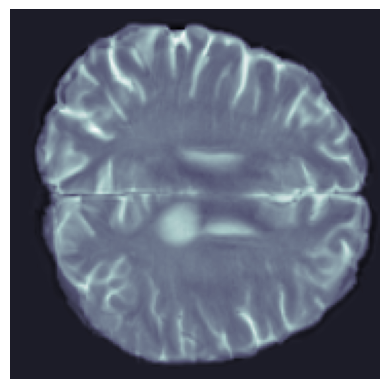

In [64]:
plt.imshow(resized_images[2][:,:,120], cmap="bone")
plt.axis("off")
plt.show()

In [ ]:
import nibabel as nib
import numpy as np

def load_and_merge_sequences(file_paths):
    sequences = []
    
    for file_path in file_paths:
        # Load NIfTI file
        img = nib.load(file_path)
        
        # Get the image data
        img_data = img.get_fdata()
        
        # Normalize the intensity values (optional but often useful)
        img_data = (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data))

        # Add the sequence to the list
        sequences.append(img_data)

    # Convert the list of sequences into a numpy array with the fourth axis
    merged_array = np.stack(sequences, axis=-1)

    return merged_array

# Example usage:
# Replace the file_paths list with the paths to your NIfTI files for each sequence
file_paths = ['path_to_T1w.nii', 'path_to_T2w.nii', 'path_to_T2-FLAIR.nii', 'path_to_T1ce.nii']

merged_data = load_and_merge_sequences(file_paths)

# Now, merged_data is a numpy array with shape (x, y, z, 4), where the fourth axis represents the different MRI sequences

[[-4.43108463 -4.43108463 -4.43108463 ... -4.43108463 -4.43108463
  -4.43108463]
 [-4.43108463 -4.43108463 -4.43108463 ... -4.43108463 -4.43108463
  -4.43108463]
 [-4.43108463 -4.43108463 -4.43108463 ... -4.43108463 -4.43108463
  -4.43108463]
 ...
 [-4.43108463 -4.43108463 -4.43108463 ... -4.43108463 -4.43108463
  -4.43108463]
 [-4.43108463 -4.43108463 -4.43108463 ... -4.43108463 -4.43108463
  -4.43108463]
 [-4.43108463 -4.43108463 -4.43108463 ... -4.43108463 -4.43108463
  -4.43108463]]


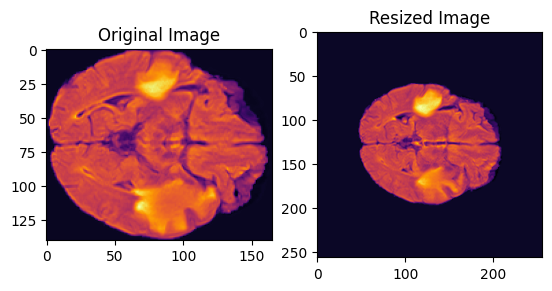

In [40]:
import numpy as np
import nibabel as nib
from skimage import transform
import os
import matplotlib.pyplot as plt

def resize_nifti_images(file_paths, target_shape):
    resized_images = []

    for file_path in file_paths:
        # Load NIfTI file using nibabel
        img = nib.load(file_path)
        data = img.get_fdata()

        current_shape = data.shape

        # Calculate the scaling factors for each dimension
        scale_factors = [target_dim / current_dim for target_dim, current_dim in zip(target_shape, current_shape)]

        # Resize the image using skimage.transform.resize
        resized_data = transform.resize(data, target_shape, mode='constant', anti_aliasing=True)

        # Create a new NIfTI image with the resized data
        resized_nifti = nib.Nifti1Image(resized_data, img.affine)

        resized_img = resized_nifti.get_fdata()

        # Save the resized NIfTI image if needed
        #resized_file_path = os.path.join('resized', os.path.basename(file_path))
        #nib.save(resized_img, resized_file_path)

        resized_images.append(resized_img)

    return resized_images


def pad_nifti_images(file_paths, target_shape):
    padded_images = []

    for file_path in file_paths:
        # Load NIfTI file using nibabel
        img = nib.load(file_path)
        data = img.get_fdata()

        current_shape = data.shape

        # Calculate the padding amounts for each dimension
        pad_widths = [(0, max(0, target_dim - current_dim)) for target_dim, current_dim in zip(target_shape, current_shape)]

        # Pad the image using numpy.pad
        padded_data = np.pad(data, pad_widths, mode='constant')

        # Create a new NIfTI image with the padded data
       # padded_img = nib.Nifti1Image(padded_data, img.affine)

        # Save the padded NIfTI image if needed
        #padded_file_path = os.path.join('padded', os.path.basename(file_path))
        #nib.save(padded_img, padded_file_path)

        padded_images.append(padded_data)

    return padded_images

def pad_nifti_images_min_value(file_paths, target_shape):
    padded_images = []

    for file_path in file_paths:
        # Load NIfTI file using nibabel
        img = nib.load(file_path)
        data = img.get_fdata()

        current_shape = data.shape

        # Find the minimum value in the original image
        min_value = data[:,:,0][0]

        # Calculate the padding amounts for each dimension
        pad_widths = []
        for target_dim, current_dim in zip(target_shape, current_shape):
            total_padding = max(0, target_dim - current_dim)
            padding_before = total_padding // 2
            padding_after = total_padding - padding_before
            pad_widths.append((padding_before, padding_after))

        # Pad the image using numpy.pad with the minimum value
        padded_data = np.pad(data, pad_widths, mode='constant', constant_values=-4.43108463)

        # Create a new NIfTI image with the padded data
        #padded_img = nib.Nifti1Image(padded_data, img.affine)

        # Save the padded NIfTI image if needed
        #padded_file_path = os.path.join('padded_min_value', os.path.basename(file_path))
        #nib.save(padded_img, padded_file_path)

        padded_images.append(padded_data)

    return padded_images

# Example usage:
# Assuming 'file_paths' is a list containing paths to your NIfTI files

# Define the target shape you want
target_shape = (256, 256, 256)  # Adjust as needed
images = ["/Users/LennartPhilipp/Desktop/sub-01005630/sub-01005630_FLAIR_preprocessed.nii.gz", "/Users/LennartPhilipp/Desktop/sub-01005630/sub-01005630_T1w_preprocessed.nii.gz", "/Users/LennartPhilipp/Desktop/sub-01005630/sub-01005630_T2w_preprocessed.nii.gz", "/Users/LennartPhilipp/Desktop/sub-01005630/sub-01005630_T1c_preprocessed.nii.gz"]

# Resize the NIfTI files
resized_nifti_images = resize_nifti_images(["/Users/LennartPhilipp/Desktop/sub-01005630/sub-01005630_FLAIR_preprocessed.nii.gz", "/Users/LennartPhilipp/Desktop/sub-01005630/sub-01005630_T1w_preprocessed.nii.gz", "/Users/LennartPhilipp/Desktop/sub-01005630/sub-01005630_T2w_preprocessed.nii.gz", "/Users/LennartPhilipp/Desktop/sub-01005630/sub-01005630_T1c_preprocessed.nii.gz"], (256,256,256))

paded_nifti_images = pad_nifti_images_min_value(images, target_shape)


original_image = nib.load(images[0]).get_fdata()


# Display an example of the original and resized image
plt.subplot(1, 2, 1)
plt.imshow(original_image[:, :, 60], cmap='inferno')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(paded_nifti_images[0][:, :, 120], cmap='inferno')
plt.title('Resized Image')

print(original_image[:, :, 0])
#print(paded_nifti_images[0][:, :, 120])

## Create AI architecture

## Train AI